In [33]:
# Install required packages. This will work in Colab (internet-enabled).
# interpret is required for EBM; fallback uses scikit-learn's HistGradientBoosting.
!pip install --quiet interpret==0.3.0 scikit-learn matplotlib pandas joblib seaborn

# (Interpret versions change over time; if this fails, Colab will still run fallback code.)


In [34]:
from google.colab import files
uploaded = files.upload()
# After upload, ensure filename is 'PJM_Load_hourly.csv' or change the filename below.
for k in uploaded.keys():
  print("Uploaded:", k)


Saving PJM_Load_hourly.csv to PJM_Load_hourly (2).csv
Uploaded: PJM_Load_hourly (2).csv


In [35]:
import os
# If you uploaded via files.upload(), set filename accordingly:
DATA_FILENAME = "PJM_Load_hourly.csv"  # change if your file has different name
DATA_PATH = f"/content/{DATA_FILENAME}"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Upload the CSV in the previous cell or change DATA_PATH.")
print("Using dataset:", DATA_PATH)

ARTIFACT_DIR = "/content/artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)
print("Artifacts will be saved to:", ARTIFACT_DIR)


Using dataset: /content/PJM_Load_hourly.csv
Artifacts will be saved to: /content/artifacts


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = (10,4)
sns.set_style("whitegrid")

def save_fig(fig, fname, dpi=150):
    path = os.path.join(ARTIFACT_DIR, fname)
    fig.savefig(path, bbox_inches='tight', dpi=dpi)
    print("Saved:", path)


In [37]:
df = pd.read_csv(DATA_PATH)
print("Raw columns:", df.columns.tolist())
display(df.head())
print("\nData shape:", df.shape)


Raw columns: ['Datetime', 'PJM_Load_MW']


,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0



Data shape: (32896, 2)


In [38]:
# Detect datetime and load columns automatically (robust)
dt_col = None
for c in df.columns:
    if "date" in c.lower() or "time" in c.lower() or "timestamp" in c.lower():
        dt_col = c
        break
if dt_col is None:
    dt_col = df.columns[0]  # fallback

# Detect load column
target_col = None
for c in df.columns:
    if "load" in c.lower() or "demand" in c.lower() or "mw" in c.lower():
        target_col = c
        break
if target_col is None:
    # pick numeric column other than datetime with largest variance
    numeric = df.select_dtypes(include=[np.number])
    if numeric.shape[1] == 0:
        raise ValueError("No numeric column found for target.")
    target_col = numeric.var().idxmax()

print("Detected datetime column:", dt_col)
print("Detected target column:", target_col)

# Parse datetime and set index
df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')
if df[dt_col].isna().any():
    print("Warning: some datetime values could not be parsed. Check format.")

df = df.rename(columns={dt_col: 'timestamp', target_col: 'load'})
df = df.sort_values('timestamp').reset_index(drop=True)
df = df.set_index('timestamp')
print("After parsing, dataset range:", df.index.min(), "to", df.index.max())


Detected datetime column: Datetime
Detected target column: PJM_Load_MW
After parsing, dataset range: 1998-04-01 01:00:00 to 2002-01-01 00:00:00


Missing values (fraction):
load    0.0
dtype: float64
Post-fill missing: 0
Saved: /content/artifacts/sample_load_first_2weeks.png


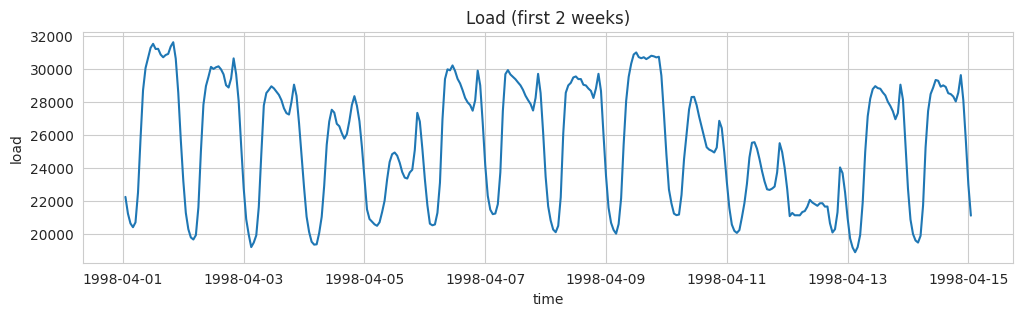

In [39]:
print("Missing values (fraction):")
print(df.isna().mean().round(4))
# Interpolate small gaps in load
if df['load'].isna().any():
    df['load'] = df['load'].interpolate(limit=24*7)
    df['load'] = df['load'].fillna(method='bfill').fillna(method='ffill')
print("Post-fill missing:", df['load'].isna().sum())

# Visualize a sample period
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df['load'].iloc[:24*14])  # first 2 weeks
ax.set_title("Load (first 2 weeks)")
ax.set_xlabel("time")
ax.set_ylabel("load")
save_fig(fig, "sample_load_first_2weeks.png")
plt.show()


In [40]:
data = df.copy()
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month
data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)

# Lag features and rolling statistics (shifted to avoid leakage)
lags = [1, 24, 168]          # 1 hour, 1 day, 1 week
windows = [3, 24, 168]      # short, daily, weekly

for lag in lags:
    data[f'lag_{lag}'] = data['load'].shift(lag)

for w in windows:
    data[f'roll_mean_{w}'] = data['load'].shift(1).rolling(window=w).mean()
    data[f'roll_std_{w}'] = data['load'].shift(1).rolling(window=w).std()

# Drop rows with NaNs due to lag/rolling
data = data.dropna()
print("Feature-engineered data shape:", data.shape)
display(data.head())


Feature-engineered data shape: (32728, 14)


,load,hour,dayofweek,month,is_weekend,lag_1,lag_24,lag_168,roll_mean_3,roll_std_3,roll_mean_24,roll_std_24,roll_mean_168,roll_std_168
timestamp,,,,,,,,,,,,,,
1998-04-08 02:00:00,20826.0,2,2,4,0,21698.0,21483.0,22259.0,23785.000000,2253.827633,26750.833333,3212.001945,25899.565476,3661.049304
1998-04-08 03:00:00,20279.0,3,2,4,0,20826.0,21211.0,21244.0,22002.000000,1353.844895,26723.458333,3261.272064,25891.035714,3671.237307
1998-04-08 04:00:00,20118.0,4,2,4,0,20279.0,21250.0,20651.0,20934.333333,715.676137,26684.625000,3334.492006,25885.291667,3679.297709
1998-04-08 05:00:00,20503.0,5,2,4,0,20118.0,21819.0,20421.0,20407.666667,371.123070,26637.458333,3421.576499,25882.119048,3684.064921
1998-04-08 06:00:00,22243.0,6,2,4,0,20503.0,23751.0,20713.0,20300.000000,193.357182,26582.625000,3511.516145,25882.607143,3683.342416


In [41]:
# Prepare X, y
X = data.drop(columns=['load'])
y = data['load']

# Time-based 80/20 split
n = len(X)
train_size = int(n * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])


Train rows: 26182 Test rows: 6546


In [42]:
from sklearn.exceptions import NotFittedError

use_ebm = False
ebm_model = None
fallback_model = None

try:
    # Import EBM
    from interpret.glassbox import ExplainableBoostingRegressor
    print("Training Explainable Boosting Regressor (EBM)... This can take a while with large data.")
    ebm_model = ExplainableBoostingRegressor(max_bins=256, max_interaction_bins=32, max_rounds=500)
    ebm_model.fit(X_train, y_train)
    use_ebm = True
    model = ebm_model
    print("EBM trained successfully.")
except Exception as e:
    print("Could not train EBM (exception):", e)
    print("Falling back to HistGradientBoostingRegressor (fast, strong).")
    from sklearn.ensemble import HistGradientBoostingRegressor
    fallback_model = HistGradientBoostingRegressor(max_iter=500, learning_rate=0.1)
    fallback_model.fit(X_train, y_train)
    model = fallback_model
    print("Fallback model trained.")


Training Explainable Boosting Regressor (EBM)... This can take a while with large data.
EBM trained successfully.


In [43]:
# Predict
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Metrics
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

print("Train MAE: {:.3f} RMSE: {:.3f} R2: {:.3f}".format(mae_train, rmse_train, r2_train))
print("Test  MAE: {:.3f} RMSE: {:.3f} R2: {:.3f}".format(mae_test, rmse_test, r2_test))

# Save model
model_path = os.path.join(ARTIFACT_DIR, "model.joblib")
joblib.dump(model, model_path)
print("Saved model to:", model_path)

# Save predictions
results = X_test.copy()
results['y_true'] = y_test
results['y_pred'] = y_pred_test
results.to_csv(os.path.join(ARTIFACT_DIR, "predictions_test.csv"))
print("Saved test predictions.")

Train MAE: 264.728 RMSE: 365.561 R2: 0.996
Test  MAE: 336.415 RMSE: 593.063 R2: 0.991
Saved model to: /content/artifacts/model.joblib
Saved test predictions.


Saved: /content/artifacts/actual_vs_predicted_sample7days.png


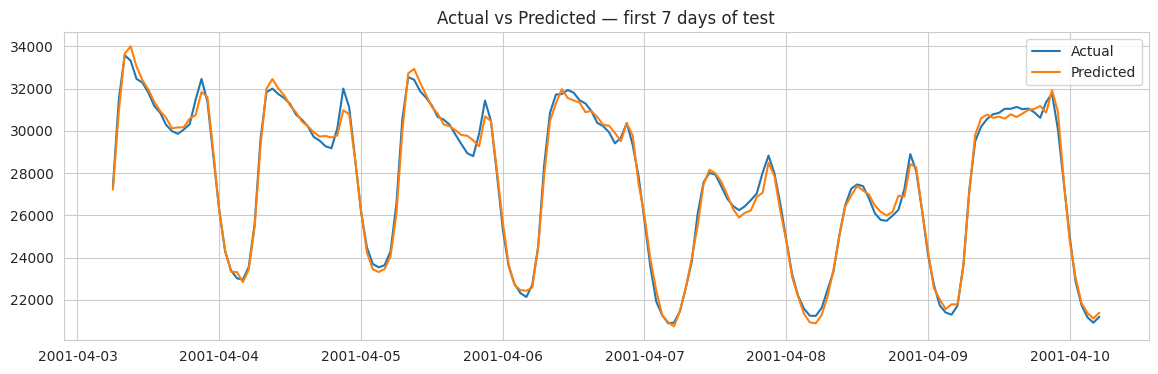

Saved: /content/artifacts/actual_vs_predicted_fulltest.png


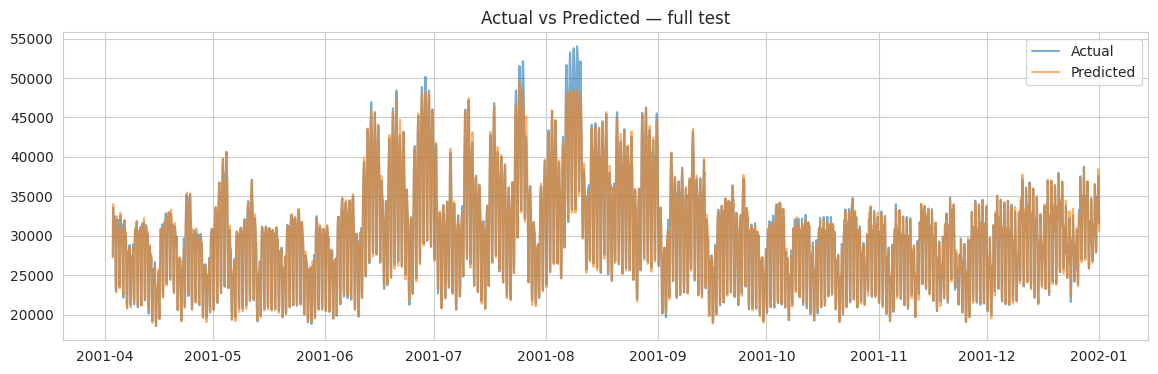

In [44]:
# Sample first 7 days of test to visualize
sample_period = results.iloc[:24*7]

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(sample_period.index, sample_period['y_true'], label='Actual')
ax.plot(sample_period.index, sample_period['y_pred'], label='Predicted')
ax.set_title("Actual vs Predicted — first 7 days of test")
ax.legend()
save_fig(fig, "actual_vs_predicted_sample7days.png")
plt.show()

# Plot full test set (downsample for visibility)
fig, ax = plt.subplots(figsize=(14,4))
ax.plot(results.index, results['y_true'], label='Actual', alpha=0.6)
ax.plot(results.index, results['y_pred'], label='Predicted', alpha=0.6)
ax.set_title("Actual vs Predicted — full test")
ax.legend()
save_fig(fig, "actual_vs_predicted_fulltest.png")
plt.show()


In [45]:
if use_ebm:
    print("Extracting EBM global explanations...")
    gexp = ebm_model.explain_global()
    # Save feature importance table
    feat_names = gexp.data().get('names', [])
    feat_scores = gexp.data().get('scores', [])
    fi_df = pd.DataFrame({'feature': feat_names, 'score': feat_scores}).sort_values('score', ascending=False)
    fi_df.to_csv(os.path.join(ARTIFACT_DIR, "ebm_feature_importances.csv"), index=False)
    print("Saved EBM feature importances.")
    # Save EBM shape functions as PNGs
    try:
        plots = gexp.data().get('plots', [])
        for p in plots:
            name = p.get('name')
            x = p.get('x', [])
            y = p.get('y', [])
            if len(x) and len(y):
                fig, ax = plt.subplots(figsize=(6,3))
                ax.plot(x, y)
                ax.set_title(f"EBM shape: {name}")
                ax.set_xlabel(name)
                ax.set_ylabel("contribution")
                fname = f"ebm_shape_{name}.png".replace(" ", "_")
                save_fig(fig, fname)
                plt.close(fig)
    except Exception as e:
        print("Could not extract plots from EBM explain_global:", e)

else:
    # Permutation importance + partial dependence
    from sklearn.inspection import permutation_importance, PartialDependenceDisplay
    print("Computing permutation importance...")
    r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    fi_df = pd.DataFrame({'feature': X_test.columns, 'importance_mean': r.importances_mean, 'importance_std': r.importances_std})
    fi_df = fi_df.sort_values('importance_mean', ascending=False).reset_index(drop=True)
    fi_df.to_csv(os.path.join(ARTIFACT_DIR, "permutation_importances.csv"), index=False)
    print("Saved permutation importances to artifacts.")

    # Partial dependence plots for top 5 features (shape-like functions)
    top5 = fi_df['feature'].tolist()[:5]
    print("Top 5 features for PDP:", top5)
    for feat in top5:
        fig, ax = plt.subplots(figsize=(6,3))
        PartialDependenceDisplay.from_estimator(model, X_test, [feat], ax=ax, kind='average')
        ax.set_title(f"Partial Dependence: {feat}")
        fname = f"pdp_{feat}.png".replace(" ", "_")
        save_fig(fig, fname)
        plt.close(fig)

Extracting EBM global explanations...
Saved EBM feature importances.


In [46]:
# Local explanations: pick 3 highest absolute error points
results_local = results.copy()
results_local['abs_error'] = (results_local['y_true'] - results_local['y_pred']).abs()
top_err = results_local.sort_values('abs_error', ascending=False).head(3)
top_err_indices = top_err.index.tolist()
print("Top error timestamps:", top_err_indices)

local_explanations = []
if use_ebm:
    for ts in top_err_indices:
        X_row = X_test.loc[[ts]]
        lexp = ebm_model.explain_local(X_row, y_test.loc[[ts]])
        # Save local explanation object to JSON-friendly dict
        local_explanations.append({'timestamp': str(ts), 'local': lexp.data()})
else:
    # For fallback, generate a local context analysis (feature percentiles and contributions approximation)
    for ts in top_err_indices:
        row = results.loc[ts]
        context = {}
        for feat in fi_df['feature'].tolist()[:10]:  # include top 10 features
            val = float(row[feat])
            train_pct = float((X_train[feat] <= val).mean())
            context[feat] = {'value': val, 'train_percentile': train_pct}
        local_explanations.append({
            'timestamp': str(ts),
            'y_true': float(row['y_true']),
            'y_pred': float(row['y_pred']),
            'abs_error': float(row['abs_error']),
            'feature_context': context
        })

# Save local explanations
with open(os.path.join(ARTIFACT_DIR, "local_explanations.json"), "w") as f:
    json.dump(local_explanations, f, indent=2)

print("Saved local explanations to local_explanations.json")

Top error timestamps: [Timestamp('2001-08-09 21:00:00'), Timestamp('2001-08-09 15:00:00'), Timestamp('2001-08-09 19:00:00')]
Saved local explanations to local_explanations.json


In [47]:
report_md = f"""
# PJM Hourly Load Forecasting — Project Report

**Dataset**: `{DATA_FILENAME}`
**Rows (after FE)**: {len(X)}
**Train / Test split**: {X_train.shape[0]} / {X_test.shape[0]}

## Model
- Model used: {'EBM (ExplainableBoostingRegressor)' if use_ebm else 'HistGradientBoostingRegressor (fallback)'}
- Train MAE: {mae_train:.3f}, RMSE: {rmse_train:.3f}, R2: {r2_train:.3f}
- Test MAE: {mae_test:.3f}, RMSE: {rmse_test:.3f}, R2: {r2_test:.3f}

## Top features (global importance)
See artifact: `{ARTIFACT_DIR}/{"ebm_feature_importances.csv" if use_ebm else "permutation_importances.csv"}`

## Global shape functions
- EBM: extracted shape plots saved as `ebm_shape_<feature>.png`
- Fallback: partial dependence plots saved as `pdp_<feature>.png`

## Local explanations
- `local_explanations.json` contains context for the 3 highest-error test timestamps.

## Files / Artifacts
- model: `{os.path.join(ARTIFACT_DIR, "model.joblib")}`
- test predictions: `{os.path.join(ARTIFACT_DIR, "predictions_test.csv")}`
- feature importances: `{os.path.join(ARTIFACT_DIR, "ebm_feature_importances.csv" if use_ebm else "permutation_importances.csv")}`
- partial dependence / ebm shapes: files beginning with `pdp_` or `ebm_shape_`
- local explanations: `{os.path.join(ARTIFACT_DIR, "local_explanations.json")}`

## Next steps (recommended to reach "world-class")
1. Merge high-quality hourly weather (temperature, humidity) from NOAA and rerun EBM. Temperature usually increases skill significantly.
2. Add holiday & event flags (grid-impacting events).
3. Hyperparameter tuning with time-series CV and potentially calibrate quantiles for probabilistic forecasts.
4. Use the EBM model as main explainable model; consider ensemble with a tuned gradient boosting model for accuracy if you need top leaderboard performance.

"""
with open(os.path.join(ARTIFACT_DIR, "report.md"), "w") as f:
    f.write(report_md)

print("Saved report to:", os.path.join(ARTIFACT_DIR, "report.md"))

# List produced files
for root, _, files in os.walk(ARTIFACT_DIR):
    for fn in files:
        print("-", fn)


Saved report to: /content/artifacts/report.md
- model.joblib
- local_explanations.json
- actual_vs_predicted_sample7days.png
- actual_vs_predicted_fulltest.png
- predictions_test.csv
- sample_load_first_2weeks.png
- ebm_feature_importances.csv
- report.md


In [48]:
import shutil
shutil.make_archive("/content/project_artifacts", 'zip', ARTIFACT_DIR)
print("Packaged artifacts to /content/project_artifacts.zip")

# Provide download link in Colab
from google.colab import files
print("You can download the zip file now (this will prompt a browser download).")
files.download("/content/project_artifacts.zip")


Packaged artifacts to /content/project_artifacts.zip
You can download the zip file now (this will prompt a browser download).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>